In [2]:
# Load packages 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib_venn import venn3, venn3_circles

# 1 Data Import 

In [3]:
# IMPORT raw data from deg (Rstudio)
deg_na = pd.read_csv('comp_anoxia_normoxia.csv', header=0, sep=',').assign(regulation='up', condition='Normoxia to Anoxia').rename(columns={'Unnamed: 0':'transcript_id'})
deg_nr = pd.read_csv('comp_reoxygenation_normoxia.csv', header=0, sep=',').assign(regulation='up', condition='Normoxia to Reoxygenation').rename(columns={'Unnamed: 0':'transcript_id'})
deg_ar = pd.read_csv('comp_anoxia_reoxygenation.csv', header=0, sep=',').assign(regulation='up', condition='Anoxia to Reoxygenation').rename(columns={'Unnamed: 0':'transcript_id'})

# identified lncRNAs
# IMPORT DATA FROM COMMON
common = pd.read_csv('/home/maggy/LncRNA/6_identify_common_lncRNA/common_lncrna_transcript_id.csv')



In [4]:
# drop rows that contains NaN in the padj column 
deg_na = deg_na.dropna(subset=['padj'])
deg_nr = deg_nr.dropna(subset=['padj'])
deg_ar = deg_ar.dropna(subset=['padj'])

# filter for NaN in log2FoldChange column 
deg_na = deg_na.dropna(subset=['log2FoldChange'])
deg_nr = deg_nr.dropna(subset=['log2FoldChange'])
deg_ar = deg_ar.dropna(subset=['log2FoldChange'])

In [5]:
# substitute MSTRG in the dfs to STRG (to get the same format) 
# convert everything in lower case letters
degs = [deg_na, deg_nr, deg_ar]

def process_dfs(dfs):
    """
    Process a list of DataFrames to replace 'MSTRG.' with 'STRG.' in 'transcript_id' column
    and convert 'transcript_id' entries to lowercase.
    
    Parameters:
    dfs (list): List of DataFrames to process
    
    Returns:
    list: List of processed DataFrames
    """
    processed_dfs = []
    for df in dfs:
        df['transcript_id'] = df['transcript_id'].str.replace('MSTRG.', 'STRG.')
        df['transcript_id'] = df['transcript_id'].str.lower()
        processed_dfs.append(df)
    return processed_dfs

process_dfs(degs)   

[       transcript_id       baseMean  log2FoldChange     lfcSE      stat  \
 0           strg.2.1       2.153152        2.345862  0.971524  2.025016   
 1           strg.3.1       1.333318        0.527247  0.971577  0.153087   
 2           strg.4.1       3.869676       -0.165478  0.568838  0.000000   
 4          strg.11.1      27.072431        0.262793  0.224295  0.000000   
 5          strg.11.2      27.072431        0.262793  0.224295  0.000000   
 ...              ...            ...             ...       ...       ...   
 145167  strg.89495.1  422251.510644       -0.361207  0.193157  0.000000   
 145168  strg.89496.1   86935.452267       -0.390009  0.224370 -0.051244   
 145169  strg.89497.1   48988.191172       -1.393479  0.413131 -2.456767   
 145170  strg.89498.1   78608.851796        0.067918  0.199356  0.000000   
 145171  strg.89499.1       1.387587       -0.186551  0.982483  0.000000   
 
           pvalue      padj regulation           condition  
 0       0.042866  0.1503

In [6]:
# set threshold for fold change 
fold_threshold = 1.3 
p_threshold = 0.05

# 2 Vulcano DEG and lncRNA 

In [7]:
# merge the dataframes and add column with name of comparison
deg = pd.concat([deg_na, deg_nr, deg_ar])

# calculate -log10(padj) for each comparison
deg['-log10p'] = -np.log10(deg['padj'])

# introduce color code 
deg['color'] = 0

# color code for significant genes
deg.loc[abs(deg['log2FoldChange']) >= np.log2(fold_threshold) , 'color'] +=1
deg.loc[deg['padj'] <= p_threshold , 'color'] +=1
deg.loc[deg['transcript_id'].isin(common['transcript_id']), 'color'] +=1

# convert number code into str for Legend labels 
deg.loc[deg['color'] <= 1, 'color'] = 'Not Differentially Expressed'
deg.loc[deg['color'] == 2, 'color'] = 'Differentially Expressed'
deg.loc[deg['color'] == 3, 'color'] = 'Differentially Expressed LncRNA'

/home/maggy/anaconda3/envs/lncrna/lib/python3.11/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [8]:
# EXPORT FOR TRANSCRIPTION EXPRESSION PLOT 
#filter for lowest padjusted value for differentially expressed 
diff_deg = deg[deg['color'] == 'Differentially Expressed LncRNA']
diff_deg = diff_deg[diff_deg['condition'] == 'Normoxia to Anoxia']
# filter for highest log2FoldChange and lowest log10p value
diff_deg = diff_deg.loc[diff_deg.groupby('transcript_id')['log2FoldChange'].idxmax()]
diff_deg = diff_deg.loc[diff_deg.groupby('transcript_id')['-log10p'].idxmax()]
#export to csv
diff_deg.to_csv('deg_data/ranking_of_most_diff_lncrna.csv', index=False, header=True)


In [9]:
deg['color'].value_counts()

color
Not Differentially Expressed       297216
Differentially Expressed            95451
Differentially Expressed LncRNA      5225
Name: count, dtype: int64

In [10]:
# Vulcano plot
def add_deg_number(data, **kwargs):
    """Add the number of DEGs to each subplot."""
    if np.all(data['color'] == 'Not Differentially Expressed'):
        return 
    elif np.all(data['color'] == 'Differentially Expressed'):
        #(deg_na['log2FoldChange'] >= np.log2(fold_threshold)) & (deg_na['padj'] <= p_threshold )
        pos = sum((data['log2FoldChange'] >= np.log2(fold_threshold)) & (data['padj'] <= p_threshold))
        neg = sum((data['log2FoldChange'] <= -np.log2(fold_threshold)) & (data['padj'] <= p_threshold))
        plt.text(x=-15, y=250, s=fr'$\downarrow${neg}', fontsize=8, ha='center', va='center')
        plt.text(x=+15, y=250, s=fr'$\uparrow${pos}', fontsize=8, ha='center', va='center')
    elif np.all(data['color'] == 'Differentially Expressed LncRNA'):
        poslnc = sum((data['log2FoldChange'] >= np.log2(fold_threshold)) & (data['padj'] <= p_threshold) & (data['transcript_id'].isin(common['transcript_id'])))
        neglnc = sum((data['log2FoldChange'] <= -np.log2(fold_threshold)) & (data['padj'] <= p_threshold) & (data['transcript_id'].isin(common['transcript_id'])))
        plt.text(x=-15, y=200, s=fr'$\downarrow${neglnc}', fontsize=8, ha='center', va='center')
        plt.text(x=+15, y=200, s=fr'$\uparrow${poslnc}', fontsize=8, ha='center', va='center')

/home/maggy/anaconda3/envs/lncrna/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)
/home/maggy/anaconda3/envs/lncrna/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)
/home/maggy/anaconda3/envs/lncrna/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)
/home/maggy/anaconda3/envs/lncrna/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


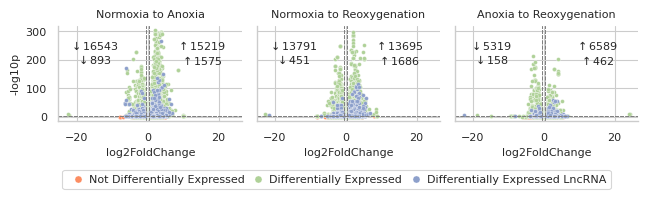

In [11]:
# create subplot for 3 plots 
sns.set_theme(style = 'whitegrid', palette='colorblind', context='paper', rc={'axes.labelsize':8, 'xtick.labelsize':8, 'ytick.labelsize':8, 'legend.fontsize':8, 'legend.title_fontsize':8})

g = sns.FacetGrid(deg, col="condition", hue='color', palette=['#FC8D62', '#AFD198', '#8DA0CB'], height=((4.5)/2.54), aspect=(17/4.5)/3, hue_order=['Not Differentially Expressed', 'Differentially Expressed', 'Differentially Expressed LncRNA'])
g.refline(y=-np.log10(p_threshold), linestyle='--', linewidth=0.7, color='grey')
g.refline(x = np.log2(fold_threshold), linestyle='--', linewidth=0.7, color='grey')
g.refline(x = -np.log2(fold_threshold), linestyle='--', linewidth=0.7, color='grey')
g.map(sns.scatterplot, 'log2FoldChange','-log10p', s=8, rasterized=True)
g.add_legend(title='', fontsize=8, loc='upper center', borderaxespad=0.1, ncol=3, bbox_to_anchor=(.28, 0.02), frameon=True, markerscale=1.8, 
            columnspacing=0.2, scatteryoffsets=[0.5], handletextpad=0.01)
g.set_titles(col_template="{col_name}", fontsize=8)
g.map_dataframe(add_deg_number)
g.tight_layout()

# save as png
g.savefig('vulcano_deg_transcripts.svg', dpi=600)
plt.show()

# 3 Venn plot

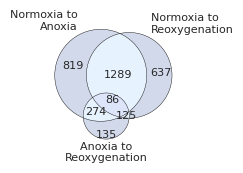

In [12]:
# Filter differentially expressed lncRNAs by condition
deg_na = set(deg[(deg['condition'] == 'Normoxia to Anoxia') & (deg['color'] == 'Differentially Expressed LncRNA')]['transcript_id'])
deg_nr = set(deg[(deg['condition'] == 'Normoxia to Reoxygenation') & (deg['color'] == 'Differentially Expressed LncRNA')]['transcript_id'])
deg_ar = set(deg[(deg['condition'] == 'Anoxia to Reoxygenation') & (deg['color'] == 'Differentially Expressed LncRNA')]['transcript_id'])

# Plotting the Venn Diagram
sns.set_theme(style='whitegrid', context='paper', rc={'axes.labelsize': 8, 'xtick.labelsize': 8, 'ytick.labelsize': 8, 'legend.fontsize': 8, 'legend.title_fontsize': 8})
plt.figure(figsize=(7.5 / 2.54, 4.25 / 2.54))

v = venn3(subsets=[deg_na, deg_nr, deg_ar], set_labels=('Normoxia to\nAnoxia', 'Normoxia to\nReoxygenation', 'Anoxia to\nReoxygenation'), set_colors=('#8DA0CB', "#8DA0CB", "#8DA0CB"))

for text in v.set_labels:
    text.set_fontsize(8)
for text in v.subset_labels:
    if text:  # Check if text is not None
        text.set_fontsize(8)

venn3_circles(subsets=[deg_na, deg_nr, deg_ar], linewidth=0.3, color='black')

# plt.title('Common Differentially Expressed Genes (DEG) between comparisons')
plt.savefig('venn_DEG_lncrna.svg')


# 4 Export data

In [13]:
# export lncRNAs 
# Filter the DataFrame for rows where 'color' is 'Differentially Expressed LncRNA'
filtered_deg = deg[deg['color'] == 'Differentially Expressed LncRNA']

for condition, group in filtered_deg.groupby('condition'):
    filename = f"deg_data/{condition}_lncrna.csv"
    group.to_csv(filename, index=False)

In [14]:
# Define the conditions and directions
conditions = ['Normoxia to Anoxia', 'Normoxia to Reoxygenation', 'Anoxia to Reoxygenation']
directions = ['up', 'down']

# Create a dictionary to store the DataFrames
deg_dict = {}

# Iterate over conditions and directions
for condition in conditions:
    for direction in directions:
        if direction == 'up':
            log_condition = deg['log2FoldChange'] >= np.log2(fold_threshold)
        else:
            log_condition = deg['log2FoldChange'] <= -np.log2(fold_threshold)
            
        # Create the filtered DataFrame
        df = deg.loc[
            (deg['condition'] == condition) &
            (deg['color'].isin(['Differentially Expressed', 'Differentially Expressed LncRNA'])) &
            (deg['padj'] <= p_threshold) &
            log_condition
        ]
        
        # Store it in the dictionary with an appropriate key
        key = f"deg_{condition.replace(' ', '_').lower()}_{direction}"
        deg_dict[key] = df
        
        # Print the length of the DataFrame
        print(f"{key}: {len(df)}")

        # Save to CSV
        df.to_csv(f'deg_data/{key}.csv', index=False)

# Now each filtered DataFrame is accessible through deg_dict.


deg_normoxia_to_anoxia_up: 16794
deg_normoxia_to_anoxia_down: 17436
deg_normoxia_to_reoxygenation_up: 15381
deg_normoxia_to_reoxygenation_down: 14242
deg_anoxia_to_reoxygenation_up: 7051
deg_anoxia_to_reoxygenation_down: 5477


In [15]:
deg[deg['color'] == 'Differentially Expressed LncRNA'].drop_duplicates(subset='transcript_id').to_csv('deg_data/deg_lncrna_transcript_id.csv', index=False)


In [18]:
deg[deg['color'] == 'Differentially Expressed LncRNA']

,transcript_id,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj,regulation,condition,-log10p,color
103,strg.115.1,118.706002,-0.743627,0.109319,-3.339909,8.380599e-04,4.101339e-03,up,Normoxia to Anoxia,2.387074,Differentially Expressed LncRNA
177,strg.167.2,59.388514,-0.877540,0.135420,-3.685057,2.286511e-04,1.217271e-03,up,Normoxia to Anoxia,2.914613,Differentially Expressed LncRNA
178,strg.167.3,45.100584,-1.080343,0.166374,-4.218411,2.460305e-05,1.480722e-04,up,Normoxia to Anoxia,3.829527,Differentially Expressed LncRNA
184,strg.171.1,663.061011,-0.866613,0.087276,-5.592593,2.237026e-08,1.849456e-07,up,Normoxia to Anoxia,6.732956,Differentially Expressed LncRNA
239,strg.219.1,7.815366,2.189626,0.435900,4.154887,3.254486e-05,1.929320e-04,up,Normoxia to Anoxia,3.714596,Differentially Expressed LncRNA
...,...,...,...,...,...,...,...,...,...,...,...
144320,strg.88724.1,35.948136,1.239142,0.269258,3.196309,1.391978e-03,1.618689e-02,up,Anoxia to Reoxygenation,1.790837,Differentially Expressed LncRNA
144349,strg.88752.1,128.489362,1.237358,0.108004,7.951975,1.835614e-15,1.157297e-13,up,Anoxia to Reoxygenation,12.936555,Differentially Expressed LncRNA
144553,strg.88956.2,32.333441,1.749520,0.240522,5.700143,1.197067e-08,3.473464e-07,up,Anoxia to Reoxygenation,6.459237,Differentially Expressed LncRNA
144730,strg.89084.1,18.475971,5.150224,1.494316,3.193241,1.406856e-03,1.633561e-02,up,Anoxia to Reoxygenation,1.786865,Differentially Expressed LncRNA


# 5 Identify the top5 DELncRNAs with the lowest padj and the biggest log2FoldCHange

In [21]:
# First, sort by `padj` in ascending order and then by absolute `log2FoldChange` in descending order
sorted_data = deg[deg['color'] == 'Differentially Expressed LncRNA'].sort_values(by=['padj', 'log2FoldChange'], ascending=[True, False])

# Get the top 5 rows from the sorted dataframe
top_10_hits = sorted_data.head(10)

# Print the top 5 hits
print(top_10_hits)

        transcript_id     baseMean  log2FoldChange     lfcSE       stat  \
3345      strg.2136.1  1398.348549        3.751644  0.095973  35.146631   
85698    strg.53453.1   466.568518       -6.182445  0.204906 -28.324791   
141884   strg.86860.1   444.336732        4.402649  0.151651  26.535461   
125294   strg.77038.1  2470.556217        2.702165  0.092527  25.113376   
60694    strg.38565.1   744.240427        3.293680  0.118916  24.514550   
18644    strg.11981.1   443.029644        2.959613  0.107993  23.900703   
97567   strg.60521.10   235.242630        3.543291  0.137141  23.076896   
118208   strg.72846.1   237.603570        4.572137  0.184259  22.759462   
18644    strg.11981.1   443.029644        2.810485  0.108159  22.485269   
141884   strg.86860.1   444.336732        3.765845  0.152377  22.229941   

               pvalue           padj regulation                  condition  \
3345    1.308649e-270  2.832747e-267         up         Normoxia to Anoxia   
85698   1.711389e-